## V_MRDH model: OD demand for different modalities

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import fiona
import pickle

#### OD matrices

In [2]:
od = {}
# Load the OD demand data: MCdashboard_VMRDH_3.0_uitlever_18-10-2023.xlsx.
od["Totaal"] = pd.read_excel('MCdashboard_VMRDH_3.0_uitlever_18-10-2023.xlsx', sheet_name='Totaal persoonsverplaatsingen', index_col=0, usecols='B:BO', nrows=65)

for modality in ["Auto", "Fiets", "OV"]:
    od[modality] = pd.read_excel('MCdashboard_VMRDH_3.0_uitlever_18-10-2023.xlsx', sheet_name=modality, index_col=0, usecols='B:BO', nrows=65)

In [3]:
od["Fiets"].iloc[3].head()

Rotterdam: Centrum             11888
Rotterdam: Delfshaven           1806
Rotterdam: Noord                8595
Rotterdam: Kralingen           60203
Rotterdam: IJsselmonde (bi)      234
Name: Rotterdam: Kralingen, dtype: int64

In [4]:
# Rename the column and row numbers to 1 to 65
for modality, df in od.items():
    df.index = range(1, 66)
    df.columns = range(1, 66)
    
od["Fiets"].head()

1      2      3      4      5     6     7     8     9     10  ...  56  \
1  55281  14088  12042  12501    296  3700   901   869  1307   772  ...   0   
2  14284  88772   6311   1994    133  1078   596  4229   666   287  ...   0   
3  12297   6330  55861   9273     92   813   194  2745  4773   631  ...   0   
4  11888   1806   8595  60203    234  1483   280   437  1936  3899  ...   0   
5    279    134     91    303  29214  5285  1385    30    37    53  ...  56   

    57  58  59  60  61  62  63  64  65  
1   10   3   0   0   0   0   0   0   0  
2    1   0   0   0   0   0   0   0   0  
3    0   0   0   0   0   0   0   0   0  
4   16   0   0   0   0   0   0   0   0  
5  269  51   0   0   0   0   0   0   0  

[5 rows x 65 columns]

#### Geo data

<Axes: >

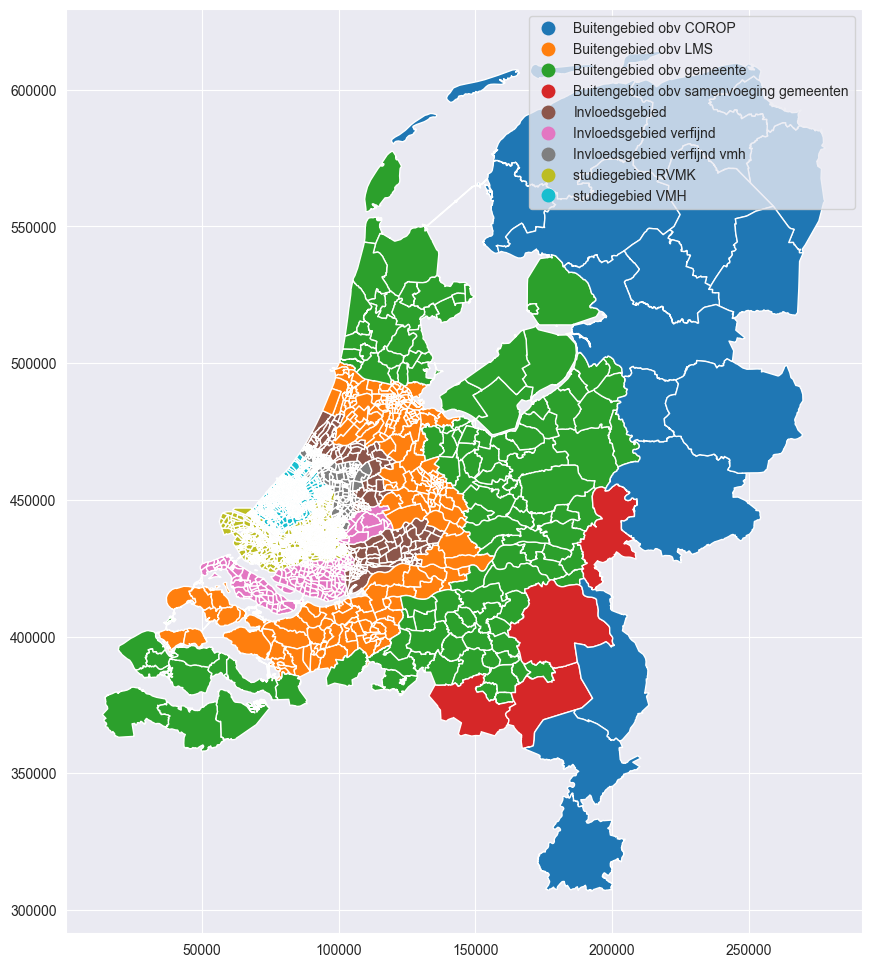

In [5]:
# Load areas_v2.json
areas = gpd.read_file('areas_v2.json')
# Set the crs to RD_New
areas.set_crs(epsg=28992, inplace=True, allow_override=True)

# Plot the areas, colored by GEBIEDEN
areas.plot(column='GEBIEDEN', legend=True, figsize=(12, 12))

In [6]:
# Print unique vlaues for GEBIEDen
areas["GEBIEDEN"].unique()

array(['studiegebied VMH', 'studiegebied RVMK',
       'Invloedsgebied verfijnd vmh', 'Invloedsgebied verfijnd',
       'Invloedsgebied', 'Buitengebied obv LMS',
       'Buitengebied obv gemeente',
       'Buitengebied obv samenvoeging gemeenten',
       'Buitengebied obv COROP'], dtype=object)

### Mapping

In [7]:
# Load 02_Segbestand_V-MRDH_3.0_uitlever_18102023.xlsx
mapping = pd.read_excel('02_Segbestand_V-MRDH_3.0_uitlever_18102023.xlsx', sheet_name='2020', skiprows=30)
mapping.head(5)

zone    65x65 Naam        plaats  65x65 Nummer  1: woningen  2: inwoners  \
0     1  Scheveningen  s-Gravenhage            25            0            0   
1     2  Scheveningen  s-Gravenhage            25            0            0   
2     3   Haagse Hout  s-Gravenhage            26           96          120   
3     4   Haagse Hout  s-Gravenhage            26          124          166   
4     5   Haagse Hout  s-Gravenhage            26          230          292   

   3: inwon0034  4: bbv  5: llp12eo  6: detail  ...  \
0             0       0           0          0  ...   
1             0       0           0          0  ...   
2             0      31           0          0  ...   
3             3      43           0          2  ...   
4             8      76           0          1  ...   

   37: vr_distributiecentrumfunctie  38: vr_kantoor  39: vr_overig  \
0                                 0               0             39   
1                                 0             452            484   
2                                 0               0              4   
3                                 0              15             46   
4                                 0              50             44   

   40:vr_terminalfunctie_m2  # auto's  auto's per hh  Unnamed: 46  \
0                         0    0.0000       0.000000       18.000   
1                         0    0.0000       0.000000        0.000   
2                         0   77.8872       0.811325       37.965   
3                         0  100.6026       0.811311       35.650   
4                         0  186.9128       0.812664       61.250   

   Unnamed: 47  Unnamed: 48  Unnamed: 49  
0        0.000     3.000000         18.0  
1        0.000     3.000000          0.0  
2        1.662    22.842960        110.7  
3        2.146    16.612302        129.6  
4        3.607    16.980871        235.8  

[5 rows x 50 columns]

In [8]:
areas.head()

AREANR NAME  CENTROIDNR           GEBIEDEN           GEMEENTEN  WONINGEN_A  \
0      69               69   studiegebied VMH         sGravenhage         580   
1    2018             2018   studiegebied VMH  Pijnacker_Nootdorp         153   
2    2032             2032   studiegebied VMH  Pijnacker_Nootdorp           4   
3    3857             3857  studiegebied RVMK       Albrandswaard         432   
4    3906             3906  studiegebied RVMK         Barendrecht           0   

   INWONERS_A  ARBEIDSPL_  LLP12EO_AR  LLP0011_AR  PARKEER_TA  AUTOSPERHH  \
0        1019         180           0           0         4.0        0.76   
1         455          12           0           0         0.0        1.09   
2          18         510           0           0         0.0        1.80   
3        1437          73           0           0         0.0        1.04   
4           0           6           0           0         0.0        0.00   

   STEDELIJKH MATRIXCOMP                 _errors  layer  \
0           5             Ring self-intersection  fixed   
1           4                  Self-intersection  fixed   
2           4             Ring self-intersection  fixed   
3           3             Ring self-intersection  fixed   
4           4             Ring self-intersection  fixed   

                                                path  \
0  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...   
1  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...   
2  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...   
3  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...   
4  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...   

                                            geometry  
0  POLYGON ((78619.991 458209.329, 78646.269 4581...  
1  MULTIPOLYGON (((86123.259 451541.607, 86115.63...  
2  POLYGON ((87473.649 452117.179, 87418.141 4521...  
3  POLYGON ((91406.125 430138.964, 91406.125 4301...  
4  POLYGON ((96024.267 431490.321, 96023.333 4314...

In [9]:
areas_2 = areas.merge(mapping, left_on='AREANR', right_on='zone', how='left')

In [10]:
# 'AREANR', 'NAME', 'CENTROIDNR', 'GEBIEDEN', 'GEMEENTEN',
#        'WONINGEN_A', 'INWONERS_A', 'ARBEIDSPL_', 'LLP12EO_AR', 'LLP0011_AR',
#        'PARKEER_TA', 'AUTOSPERHH', 'STEDELIJKH', 'MATRIXCOMP', '_errors',
#        'layer', 'path', 'zone', '65x65 Naam', 'plaats', '1: woningen',
#        '2: inwoners', '3: inwon0034', '4: bbv', '5: llp12eo', '6: detail',
#        '7: industrie', '8: rest', '9: arbeidspl_totaal', '10: gebiedstype',
#        '11: intrazonaal', '12: vrachtformule', '13: autosperhh',
#        '14: v_os_auto', '15: a_os_auto', '16: v_as_auto', '17: a_as_auto',
#        '18: v_rd_auto', '19: a_rd_auto', '20: va_mz_os', '21: va_mz_as',
#        '22: va_mz_rd', '23: va_zw_os', '24: va_zw_as', '25: va_zw_rd',
#        '26: inwon0011', '27: llp0011', '28: stedelijkheid', '29: hh 0 autos',
#        '30: hh 1 auto', '31: hh 2 autos', '32: hh 3 of meer autos',
#        '33: parkeertarief', '34: parkeerplaatsen', '35: vr_supermarktfunctie',
#        '36: vr_agrarischefunctie', '37: vr_distributiecentrumfunctie',
#        '38: vr_kantoor', '39: vr_overig', '40:vr_terminalfunctie_m2',

In [11]:
agg_dict = {'65x65 Naam': 'first', 'GEBIEDEN': 'first', 'WONINGEN_A': 'sum', 'INWONERS_A': 'sum', 'ARBEIDSPL_': 'sum', 'LLP12EO_AR': 'sum', 'LLP0011_AR': 'sum', 'PARKEER_TA': 'median', 'AUTOSPERHH': 'median', 'STEDELIJKH': 'median',
            'plaats': 'first', '1: woningen': 'sum', '2: inwoners': 'sum', '3: inwon0034': 'sum', '4: bbv': 'sum', '5: llp12eo': 'sum', '6: detail': 'sum', '7: industrie': 'sum', '8: rest': 'sum', '9: arbeidspl_totaal': 'sum',
            '10: gebiedstype': 'first'}

In [12]:
areas_2['geometry'] = areas_2['geometry'].buffer(0)

In [13]:
areas_65 = areas_2.dissolve(by='65x65 Nummer', aggfunc=agg_dict)

# Select 'studiegebied RVMK', 'studiegebied VMH' from GEBIEDEN
areas_mrdh = areas_65[areas_65['GEBIEDEN'].isin(['studiegebied RVMK', 'studiegebied VMH'])]

# Save both as pickle
areas_65.to_pickle('areas_65.pkl')
areas_mrdh.to_pickle('areas_mrdh.pkl')

areas_65.head(5)

geometry  \
65x65 Nummer                                                      
1             MULTIPOLYGON (((91572.39 435285.08, 91571.6 43...   
2             POLYGON ((89429 435269.999, 89384 435277.999, ...   
3             POLYGON ((89677.053 437491.512, 89672.17 43749...   
4             POLYGON ((93801.859 437558.61, 93800.797 43756...   
5             POLYGON ((94944.584 431561.346, 94944.374 4315...   

                     65x65 Naam           GEBIEDEN  WONINGEN_A  INWONERS_A  \
65x65 Nummer                                                                 
1             Rotterdam Centrum  studiegebied RVMK       21529       36209   
2                    Delfshaven  studiegebied RVMK       39740       77508   
3                         Noord  studiegebied RVMK       29516       52490   
4                     Kralingen  studiegebied RVMK       30714       53939   
5              IJsselmonde (bi)  studiegebied RVMK       22324       45467   

              ARBEIDSPL_  LLP12EO_AR  LLP0011_AR  PARKEER_TA  AUTOSPERHH  ...  \
65x65 Nummer                                                              ...   
1                  88158       37649        2213        4.14       0.495  ...   
2                  17468        9165        6332        1.76       0.460  ...   
3                  12453       10649        2807        1.76       0.425  ...   
4                  25025       36520        4257        1.76       0.480  ...   
5                  16658        4404        3906        0.00       0.650  ...   

              1: woningen 2: inwoners  3: inwon0034  4: bbv  5: llp12eo  \
65x65 Nummer                                                              
1                   21529       36209         18948   16284       37649   
2                   39740       77508         41160   30429        9165   
3                   29516       52490         27808   23956       10649   
4                   30714       53939         28785   19379       36520   
5                   22324       45467         19990   16927        4404   

              6: detail  7: industrie  8: rest  9: arbeidspl_totaal  \
65x65 Nummer                                                          
1                  9151          7019    71988                88158   
2                  3430          1068    12970                17468   
3                  3235           499     8719                12453   
4                  2758          4634    17633                25025   
5                  2587          1931    12140                16658   

              10: gebiedstype  
65x65 Nummer                   
1                           1  
2                           1  
3                           1  
4                           1  
5                           1  

[5 rows x 22 columns]

In [14]:
# Print unique GEBIEDEN
areas_65["GEBIEDEN"].unique()

array(['studiegebied RVMK', 'studiegebied VMH', 'Invloedsgebied',
       'Invloedsgebied verfijnd vmh', 'Invloedsgebied verfijnd',
       'Buitengebied obv LMS', 'Buitengebied obv COROP'], dtype=object)

<Axes: >

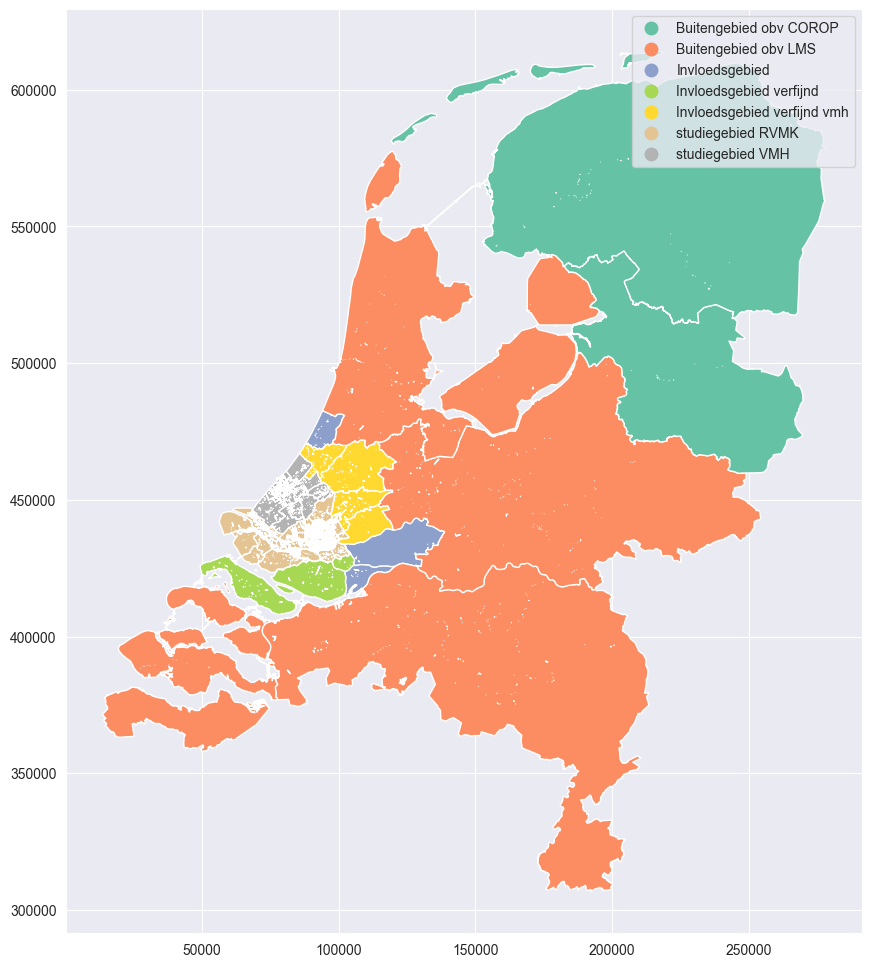

In [15]:
areas_65.plot(column="GEBIEDEN", legend=True, figsize=(12, 12), cmap='Set2')

### Plot OD demand

In [16]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

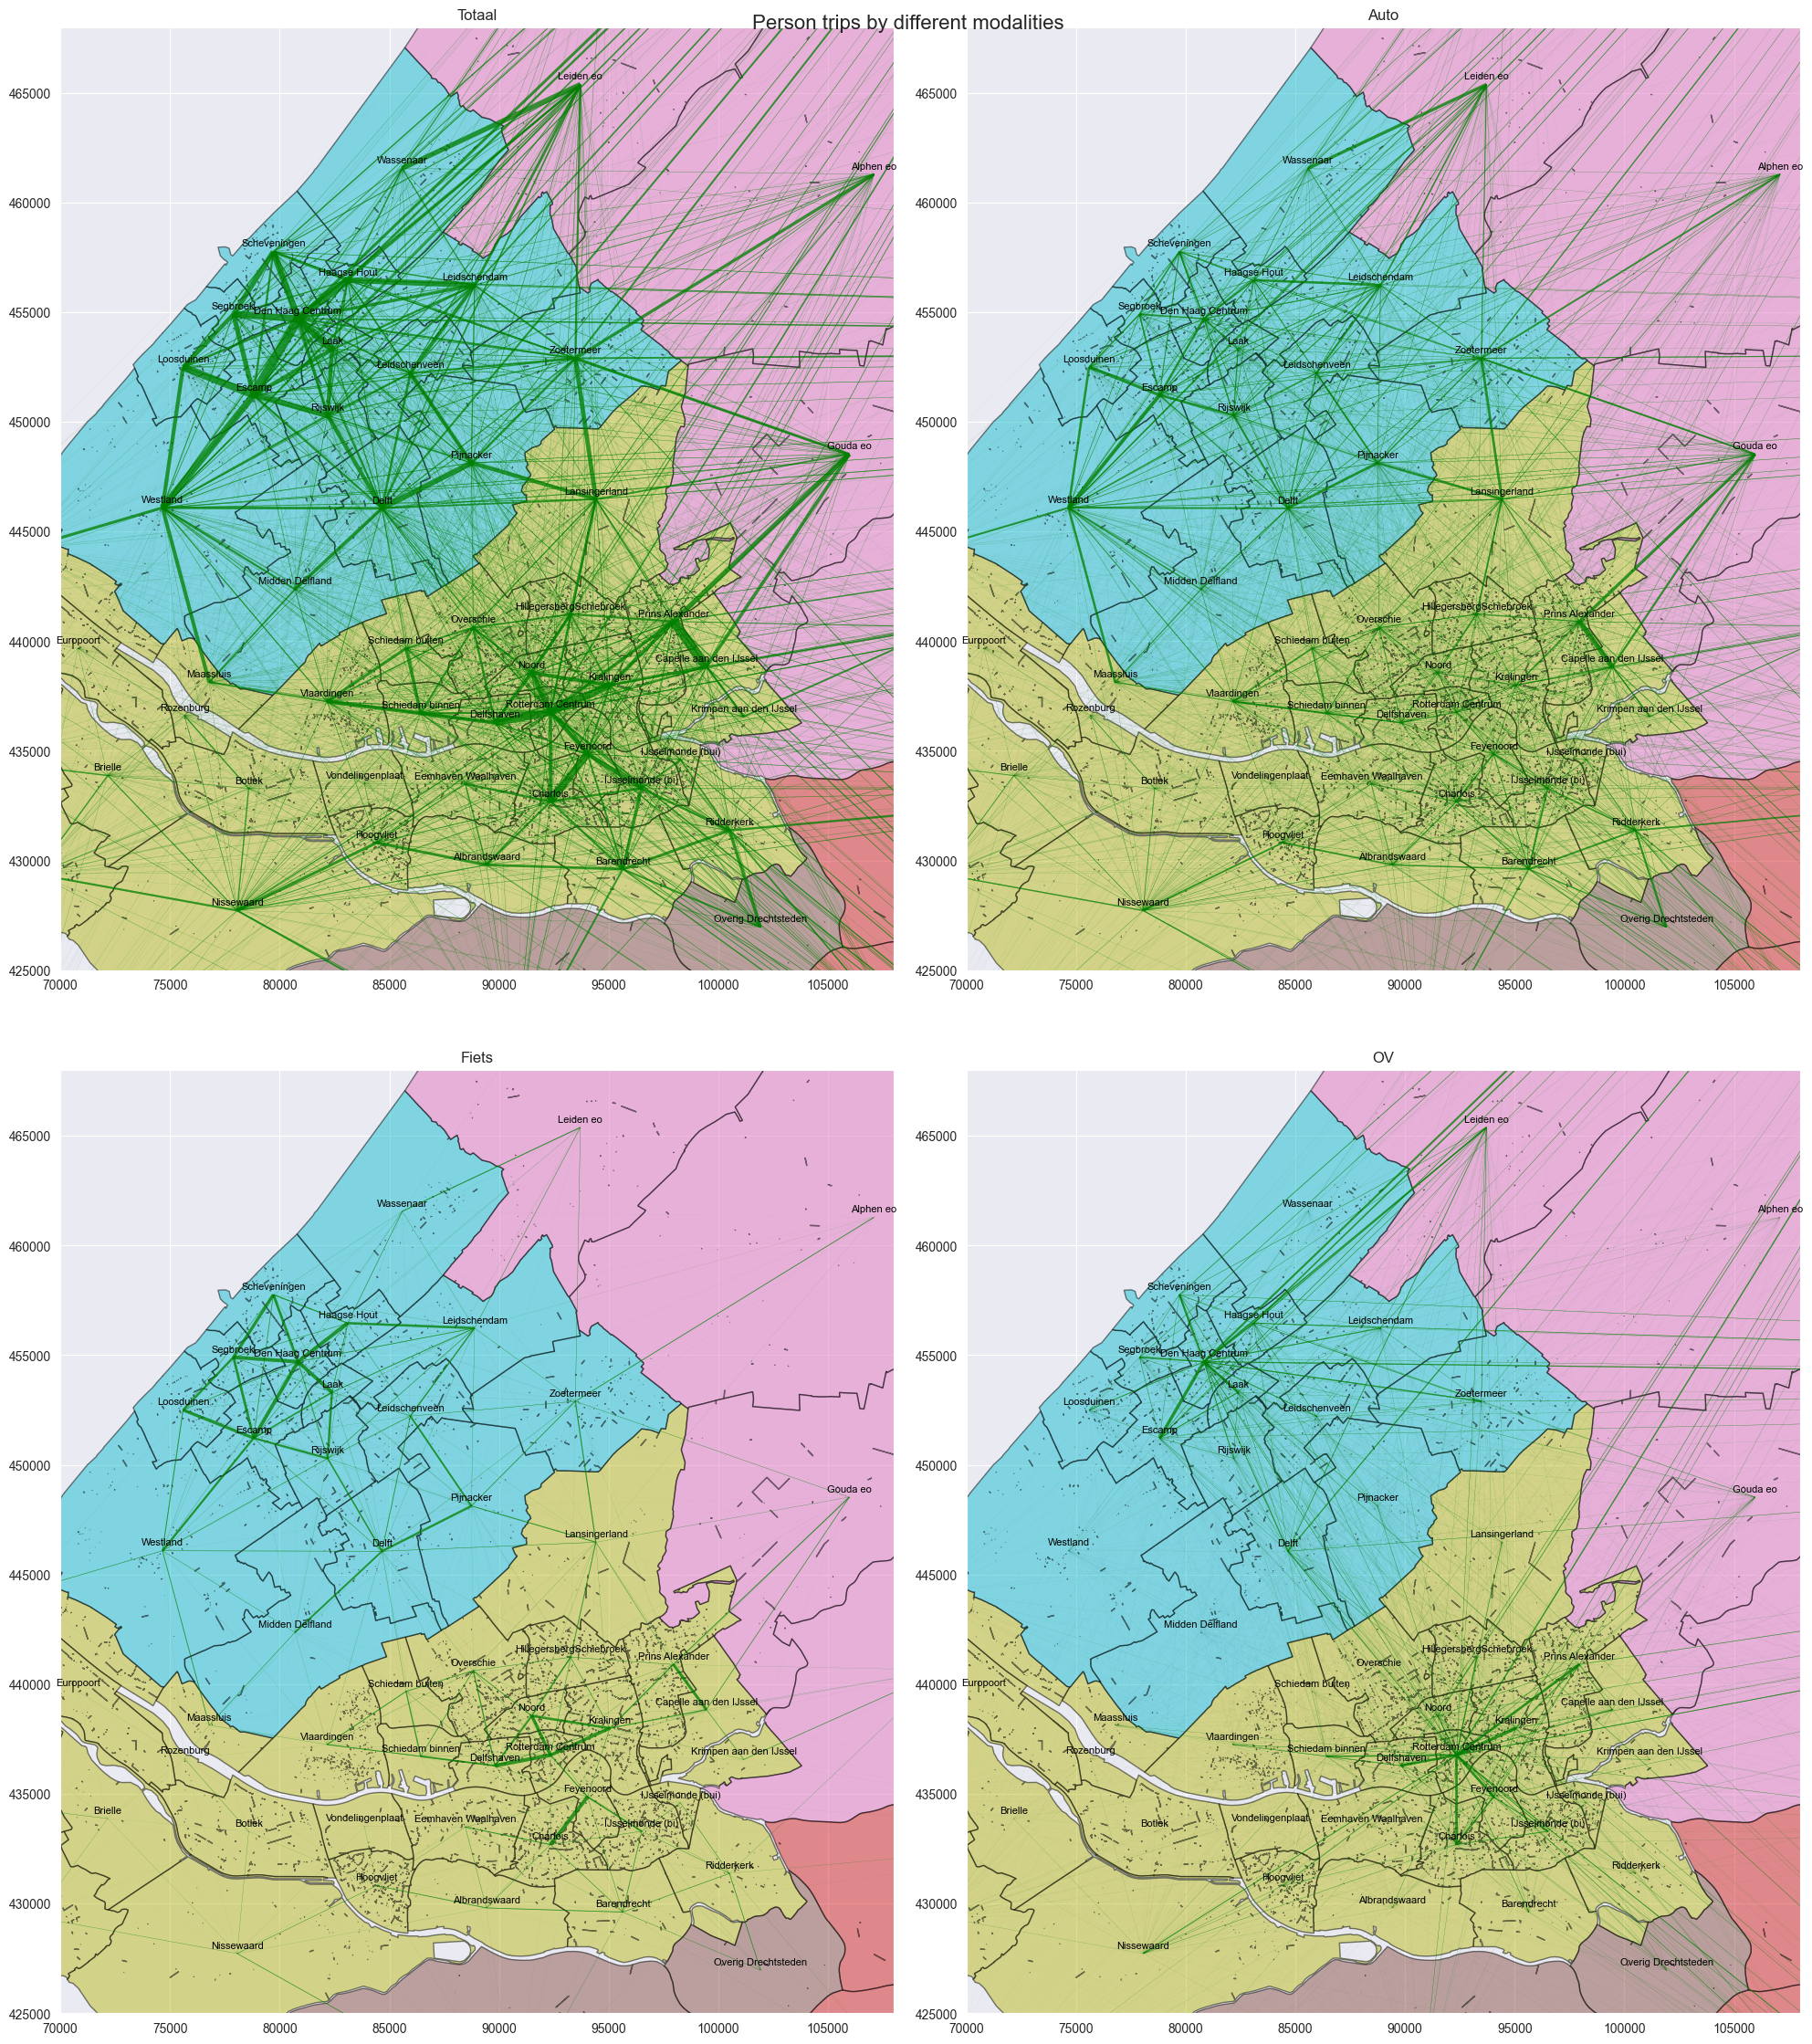

In [17]:
mod = "Totaal"

def plot_od_demand(mod, ax):
    odc = od[mod]
    lines_data = []

    for origin in odc.index:
        for destination in odc.columns:
            # Only draw the line if the origin or destination are in the Rotterdam / The Hague area
            if origin != destination and odc.at[origin, destination] > 0 and (origin in areas_mrdh.index or destination in areas_mrdh.index):
                origin_geom = areas_65.loc[origin].geometry.centroid
                destination_geom = areas_65.loc[destination].geometry.centroid
                line = LineString([origin_geom, destination_geom])
                lines_data.append({
                    'origin': origin,
                    'destination': destination,
                    'volume': odc.at[origin, destination],
                    'geometry': line
                })
    
    lines = gpd.GeoDataFrame(lines_data, geometry='geometry', crs=areas_65.crs)
    
    areas_65.plot(ax=ax, column='GEBIEDEN', edgecolor='black', alpha=0.5)
    lines.plot(ax=ax, color='green', linewidth=lines['volume'] / 5000, alpha=0.5)
    
    ax.set_xlim(70000, 108000)
    ax.set_ylim(425000, 468000)
    
    for idx, row in areas_65.iterrows():
        ax.annotate(text=row['65x65 Naam'], xy=(row.geometry.centroid.x, row.geometry.centroid.y + 250), color='black', fontsize=8, ha='center')
    
    ax.set_title(mod)
    return lines

line_dfs = {}

fig, ax = plt.subplots(2, 2, figsize=(20, 23))
for i, mod in enumerate(["Totaal", "Auto", "Fiets", "OV"]):
    line_dfs[mod] = plot_od_demand(mod, ax[i // 2, i % 2])

plt.tight_layout()
plt.suptitle("Person trips by different modalities", fontsize=16)
plt.savefig(f"od_demand.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
line_dfs["Totaal"].head()

origin  destination   volume  \
0       1            2  27481.9   
1       1            3  18481.6   
2       1            4  27248.0   
3       1            5   4469.8   
4       1            6  15619.2   

                                            geometry  
0  LINESTRING (92349.134 436764.851, 89816.179 43...  
1  LINESTRING (92349.134 436764.851, 91493.744 43...  
2  LINESTRING (92349.134 436764.851, 95052.693 43...  
3  LINESTRING (92349.134 436764.851, 96502.454 43...  
4  LINESTRING (92349.134 436764.851, 94037.56 434...

In [19]:
# Normalize: given a modality and origin, what is the chance of going to a certain destination (sum of chances is 1). Create a nested dictionary: modality -> origin -> destination -> chance
od_chance_dict = {}
for modality in ["Totaal", "Auto", "Fiets", "OV"]:
    od_chance_dict[modality] = {}
    odc = od[modality]
    for origin in odc.index:
        od_chance_dict[modality][origin] = {}
        total = odc.loc[origin].sum()
        for destination in odc.columns:
            volume = odc.at[origin, destination]
            if volume > 0:
                od_chance_dict[modality][origin][destination] = volume / total
            
print(od_chance_dict["Totaal"][1][2])
# Check if the sum of chances is 1
sum(od_chance_dict["Totaal"][1].values())

0.09520030345596858


np.float64(1.0)

In [21]:
# save the dictionaries
with open('../data/od_chance_dicts.pickle', 'wb') as f:
    pickle.dump(od_chance_dict, f)